# FORECASTING OF YAHOO STOCK

In [5]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense, LSTM
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statsmodels.api as sm
from darts.metrics import mape
from darts.models import BlockRNNModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import Prophet

In [6]:
data = pd.read_csv('yahoo_stock.csv', index_col='Date', parse_dates=True)

dataHigh = data['High']
data_close = data['Close']
train_data = data_close[:'2019']
test_data = data_close['2020':]

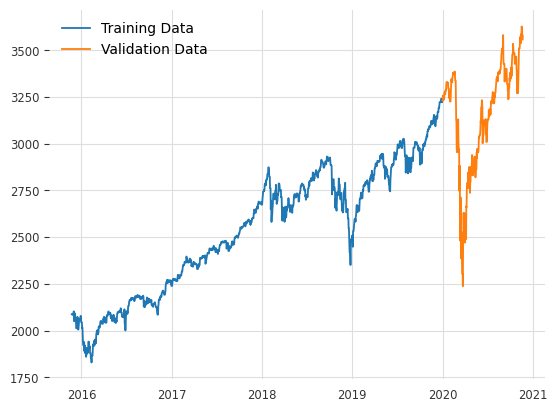

In [7]:
#training and testing data
plt.plot(train_data,label="Training Data",color='tab:blue')
plt.plot(test_data,label='Validation Data',color='tab:orange')
plt.legend()
plt.show()

# ARIMA / SARIMA

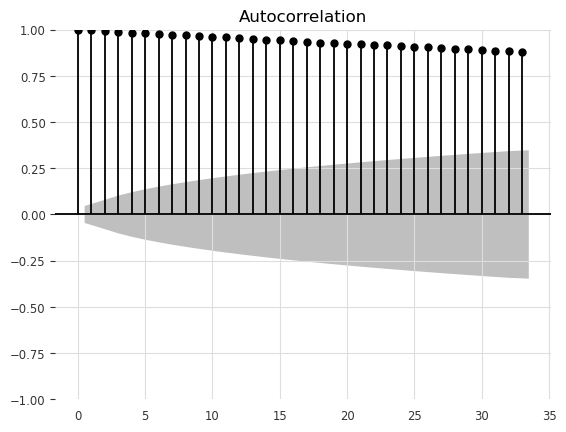

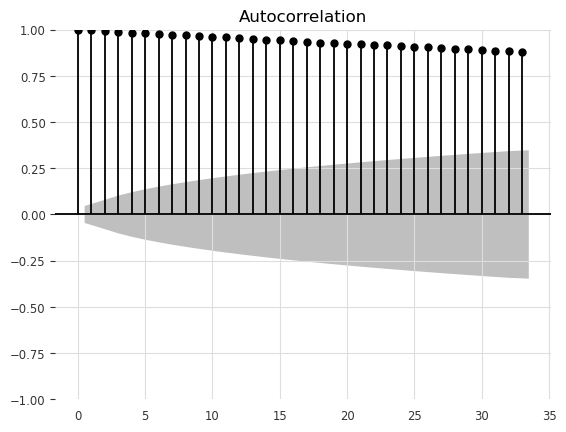

In [8]:
plot_acf(data.Close)

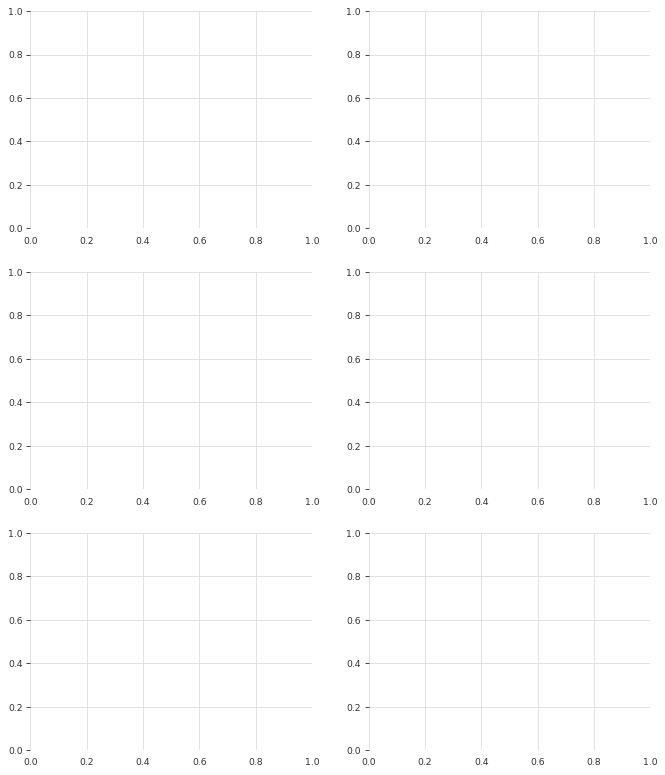

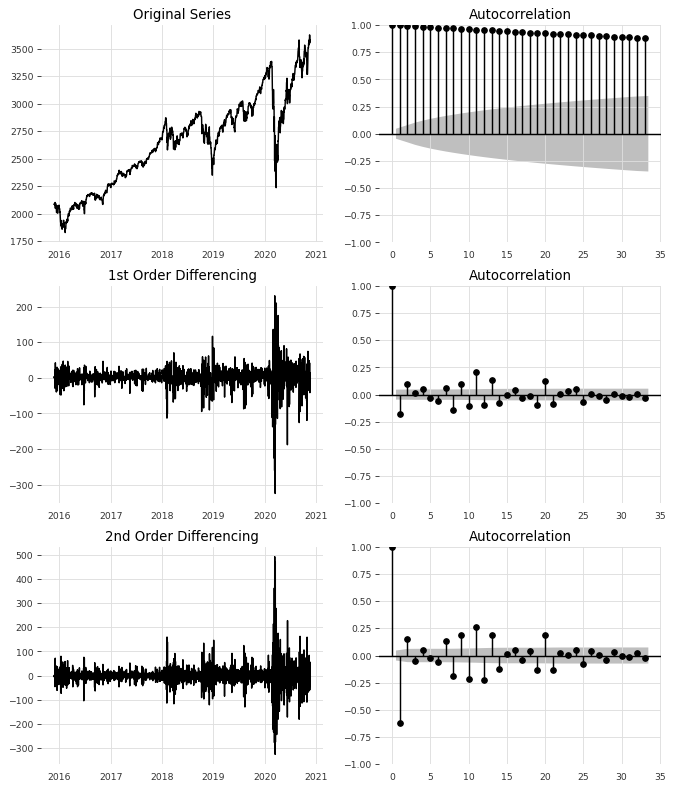

In [9]:
plt.rcParams.update({'figure.figsize':(10,12), 'figure.dpi':80})
fig, axes = plt.subplots(3, 2, sharex=False)

#Original

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(data.Close); axes[0, 0].set_title('Original Series')
plot_acf(data.Close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.Close.diff().dropna(), ax=axes[1, 1])
# 2nd Differencing
axes[2, 0].plot(data.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.Close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

C:\Users\jepp5\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


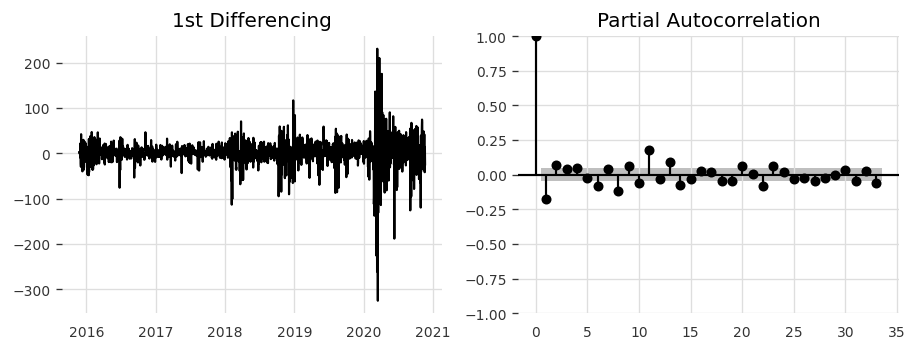

In [10]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(data.Close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.Close.diff().dropna(), ax=axes[1])

plt.show()

C:\Users\jepp5\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jepp5\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jepp5\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


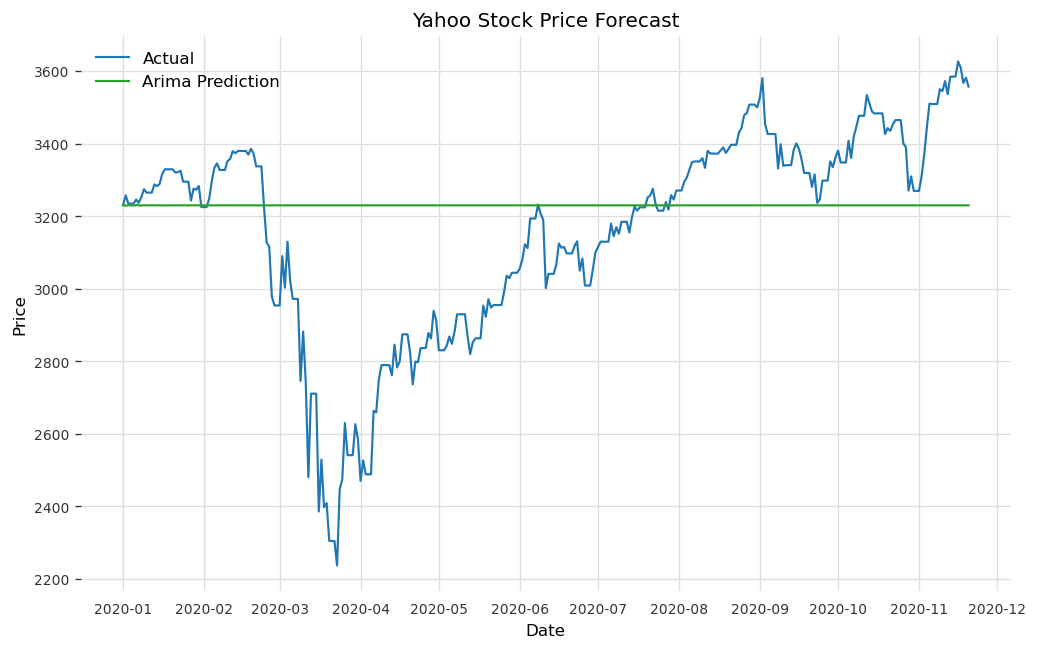

In [51]:
model = ARIMA(train_data,order=(2,1,2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test_data))
plt.figure(figsize=(10,6))
plt.plot(test_data, label='Actual',color='tab:blue')
plt.plot(forecast, label='Arima Prediction',color='tab:green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Yahoo Stock Price Forecast')
plt.legend()
plt.show()

In [11]:
adfuller(data.Close)
#Hence, non stationary

(-0.8703973870161311,
 0.7975646340657508,
 23,
 1801,
 {'1%': -3.4339861159726306,
  '5%': -2.863146142843122,
  '10%': -2.5676250581282964},
 16826.469381922303)

In [49]:
arima_model = auto_arima(train_data) 
arima_model.order
arima_model.summary() 
#Selects itself to be SARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1500
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -6381.572
Date:                Thu, 11 May 2023   AIC                          12775.145
Time:                        11:26:40   BIC                          12807.020
Sample:                    11-23-2015   HQIC                         12787.020
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1161      1.239      1.708      0.088      -0.312       4.544
ar.L1         -0.9980      0.091    -10.971      0.000      -1.176      -0.820
ar.L2         -0.7752      0.097     -8.023      0.000      -0.965      -0.586
ma.L1          0.9429      0.099      9.539      0.000       0.749       1.137
ma.L2          0.7159      0.107      6.683      0.000       0.506       0.926
sigma2       291.9399      5.201     56.135      0.000     281.747     302.133
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              3911.56
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               2.63   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
pred = pd.DataFrame(arima_model.predict(n_periods=325),index=test_data.index)

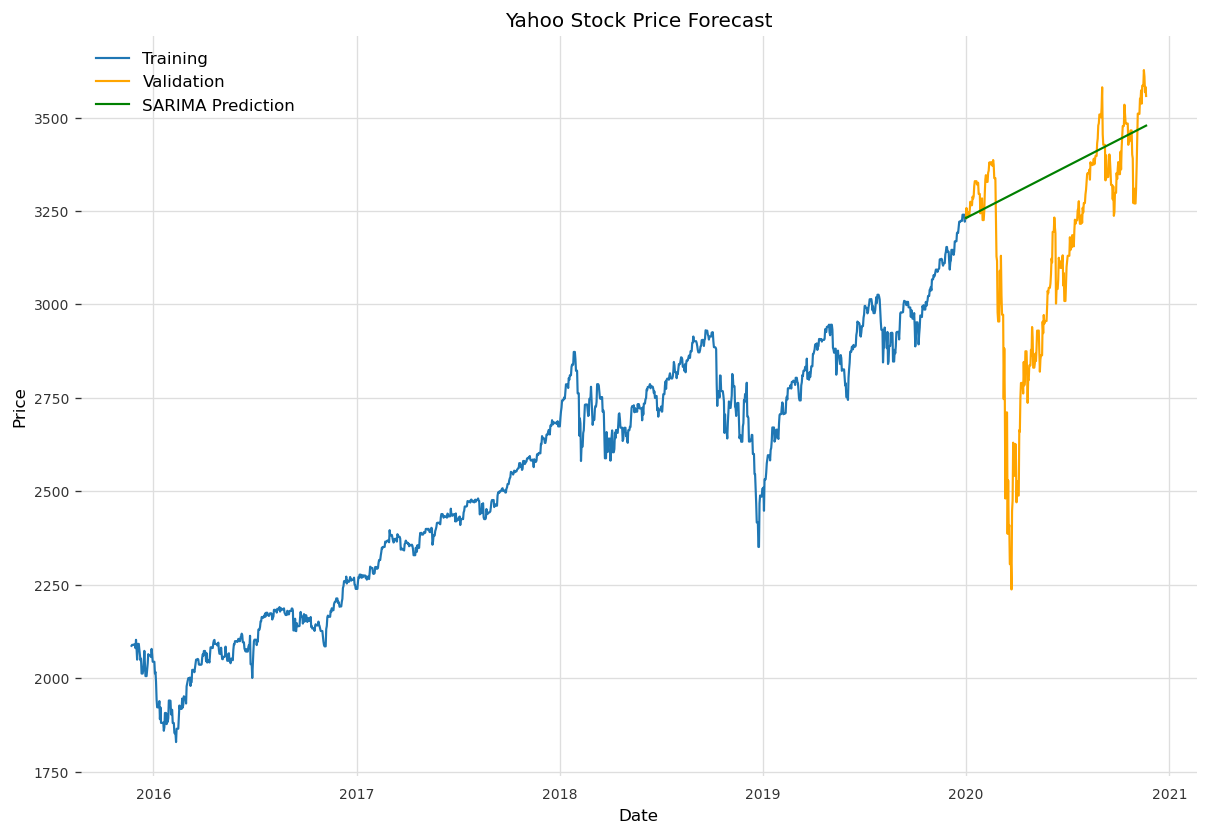

In [53]:
plt.figure(figsize=(12,8))
plt.plot(train_data,label="Training",color='tab:blue')
plt.plot(test_data,label='Validation',color='orange')
plt.plot(pred,label="SARIMA Prediction",color='green')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Yahoo Stock Price Forecast')
plt.show()

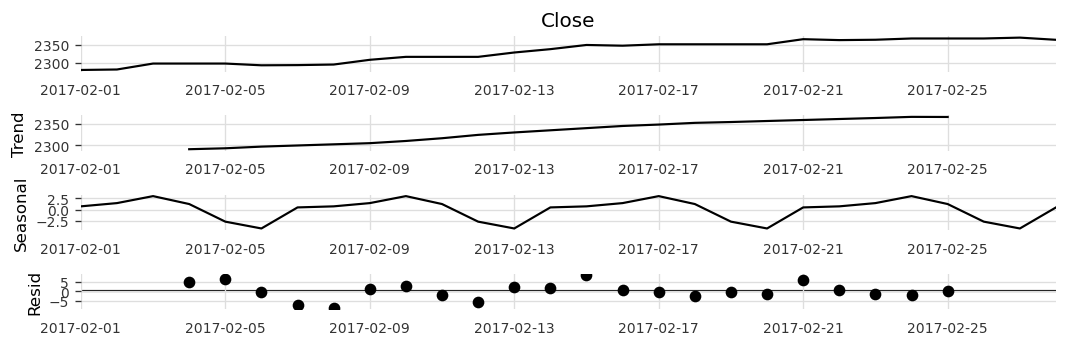

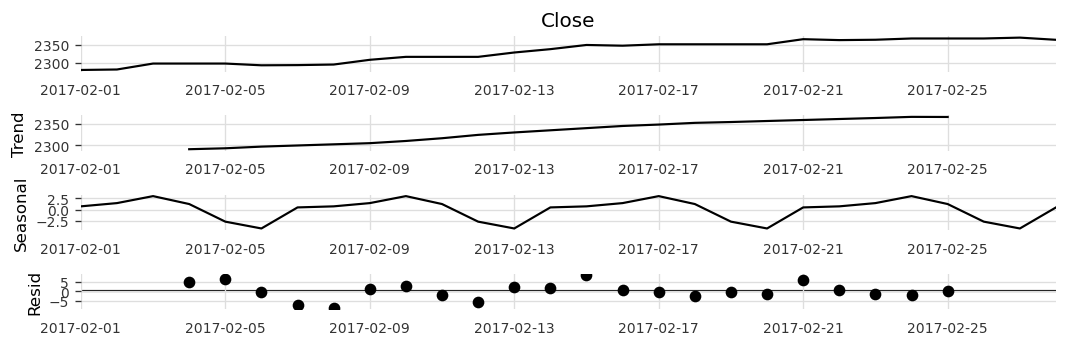

In [15]:
#using only 2017 feb to see seasonality
feb_data = data.Close['2017-02':'2017-02']
season = seasonal_decompose(feb_data)
season.plot()
#Seasonality seems to be weekly

Text(0.5, 1.0, 'Residuals')

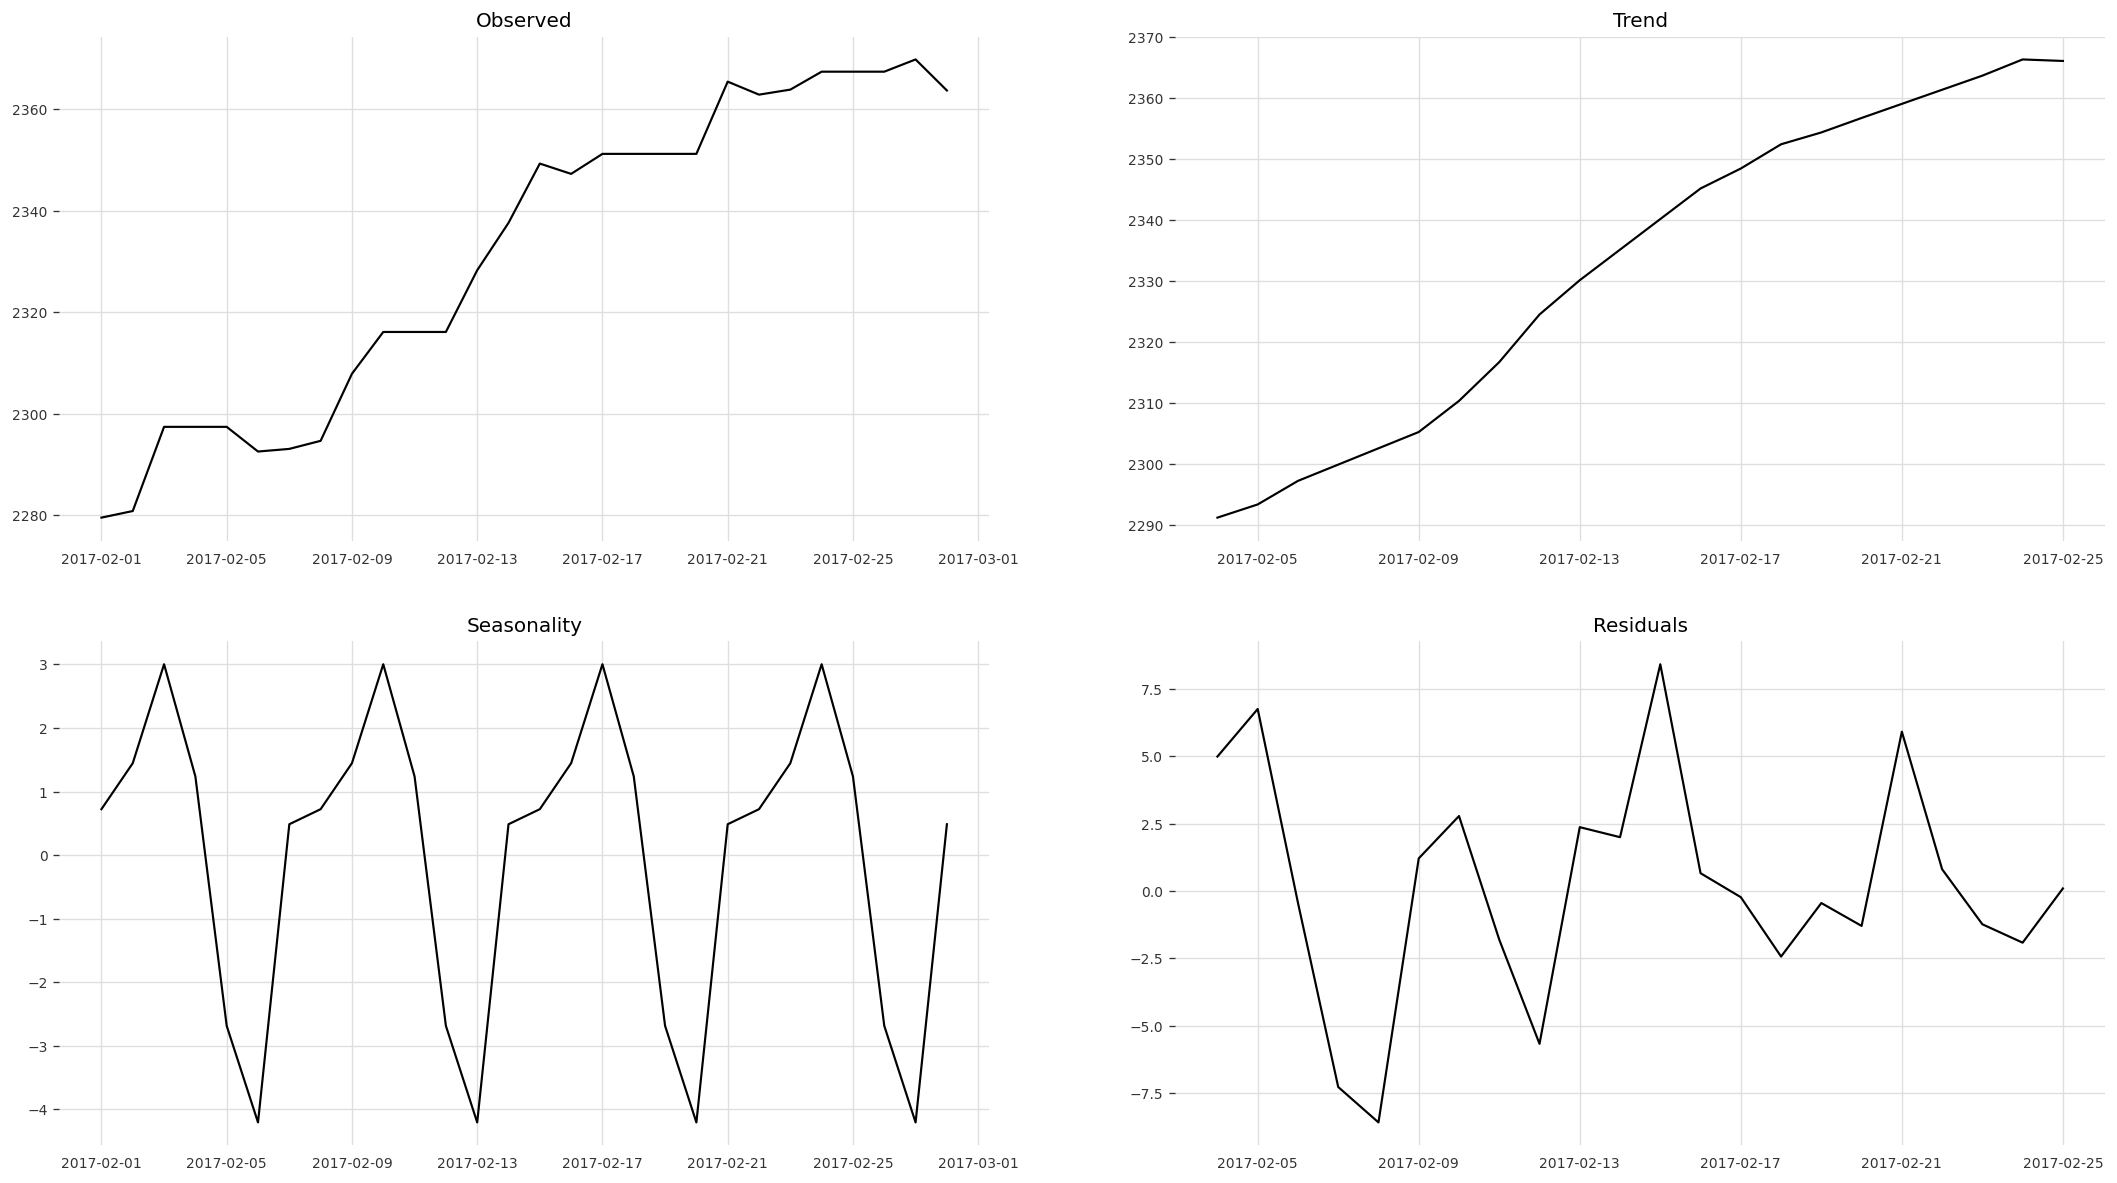

In [16]:
plt.rcParams.update({'figure.figsize':(22,12), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0,0].plot(season.observed); axes[0,0].set_title('Observed')
axes[0,1].plot(season.trend); axes[0,1].set_title('Trend')
axes[1,0].plot(season.seasonal);axes[1,0].set_title('Seasonality')
axes[1,1].plot(season.resid);axes[1,1].set_title('Residuals')

<Axes: xlabel='Date'>

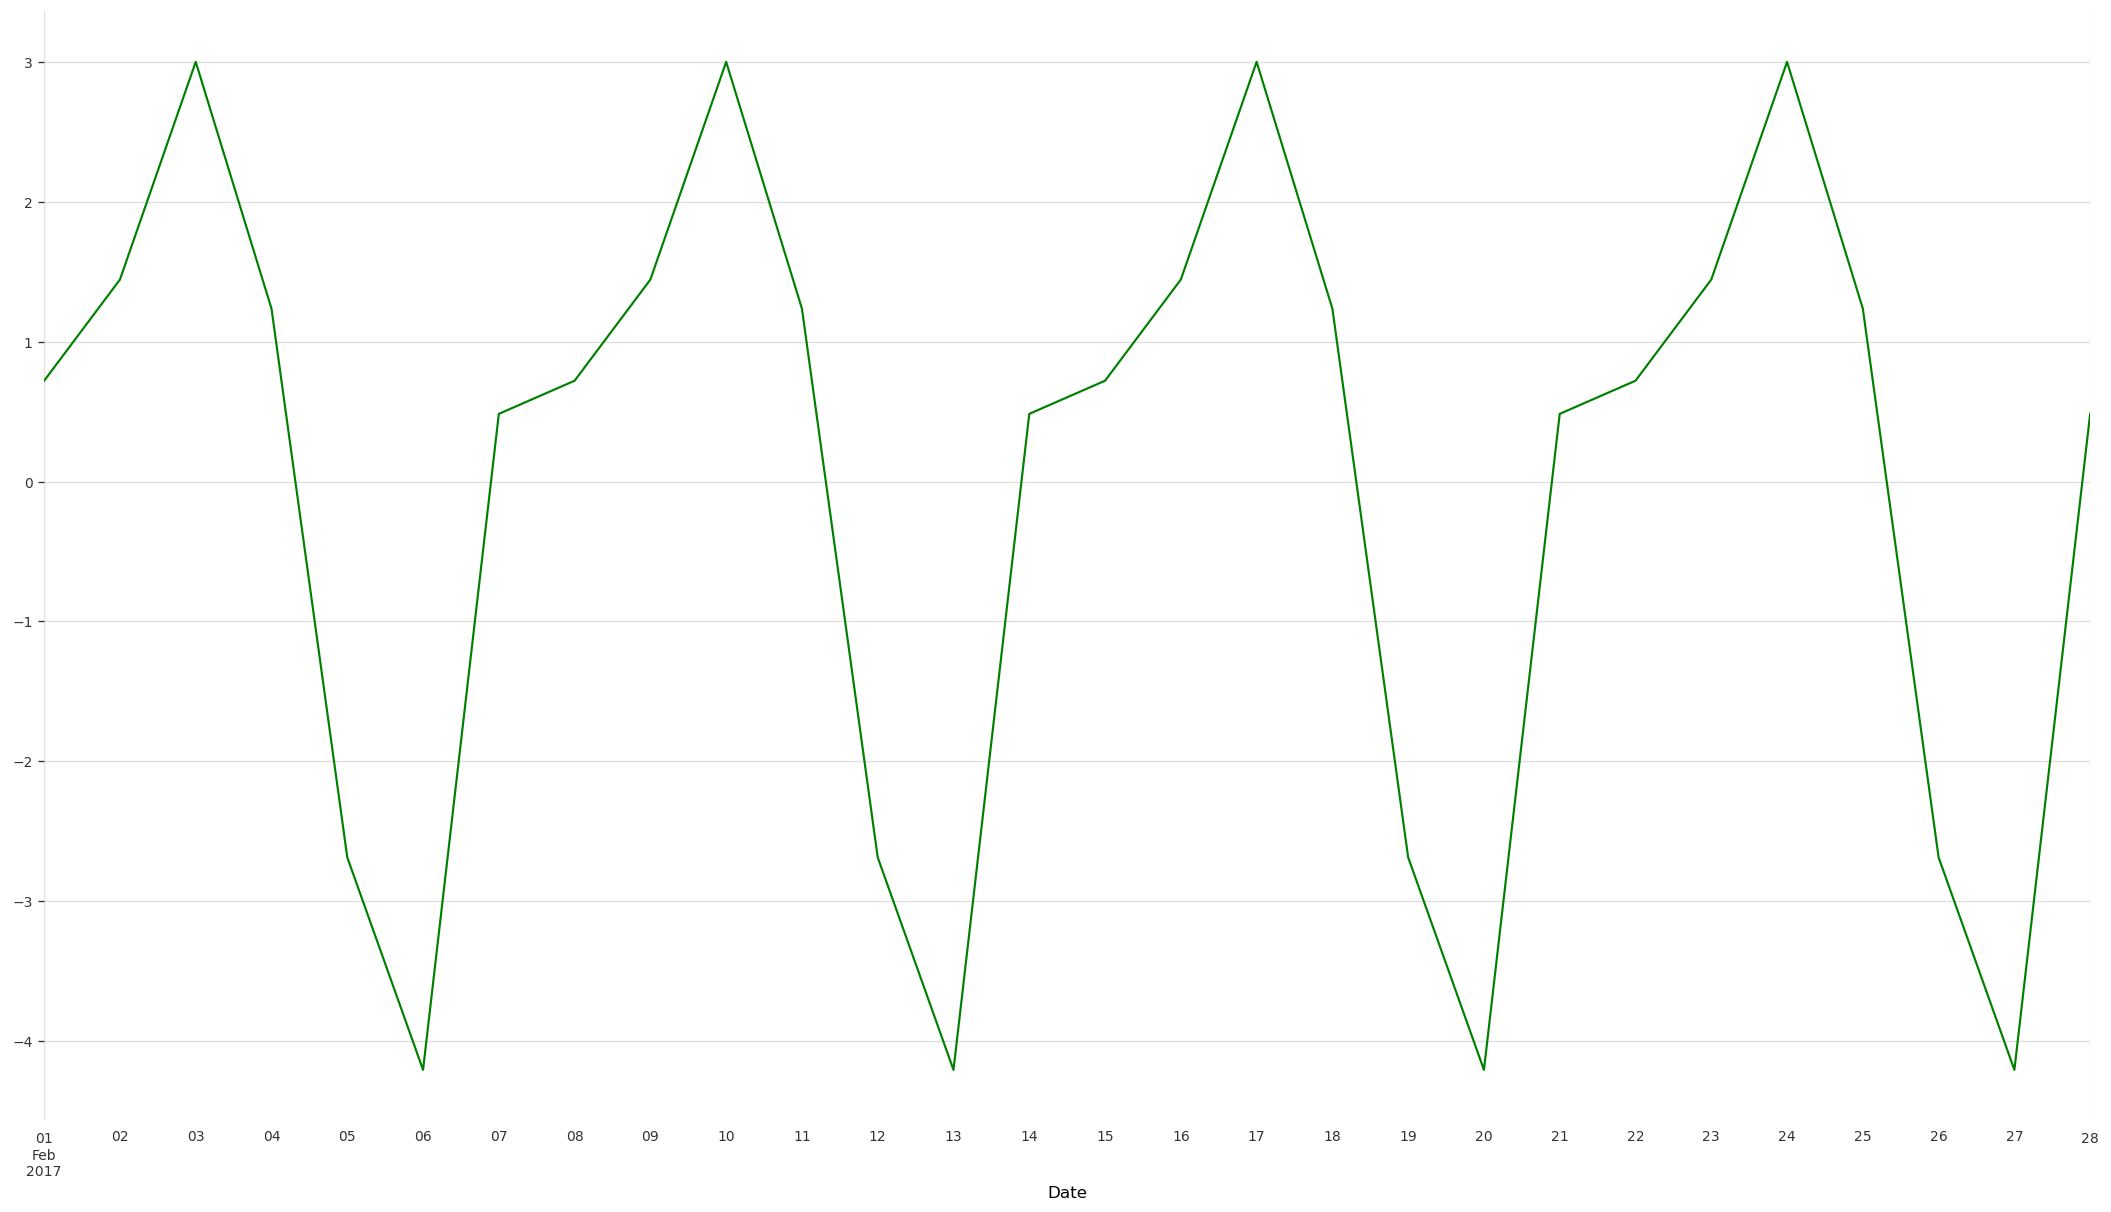

In [17]:
seasonality = season.seasonal
seasonality.plot(color='green')

In [18]:
p,d,q=arima_model.order
#timesteps per seasonlity = 7
sarim = sm.tsa.statespace.SARIMAX(train_data.to_frame(),order=arima_model.order,seasonal_order=(1,1,1,7))

#Still SARIMA (as opposed to SARIMAX) model, as exog parameters not passed 
sar_res = sarim.fit() 

C:\Users\jepp5\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jepp5\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [19]:
sar_pred = sar_res.predict(start=len(train_data),end=len(train_data)+325)
sar_pred = sar_pred.reset_index()
sar_pred = sar_pred.rename(columns={"index":"Date"})
sar_pred = sar_pred.set_index('Date')
sar_pred

,predicted_mean
Date,
2020-01-01,3232.002884
2020-01-02,3231.227074
2020-01-03,3233.753607
2020-01-04,3233.022936
2020-01-05,3233.664962
...,...
2020-11-17,3482.998426
2020-11-18,3484.754523
2020-11-19,3485.588220


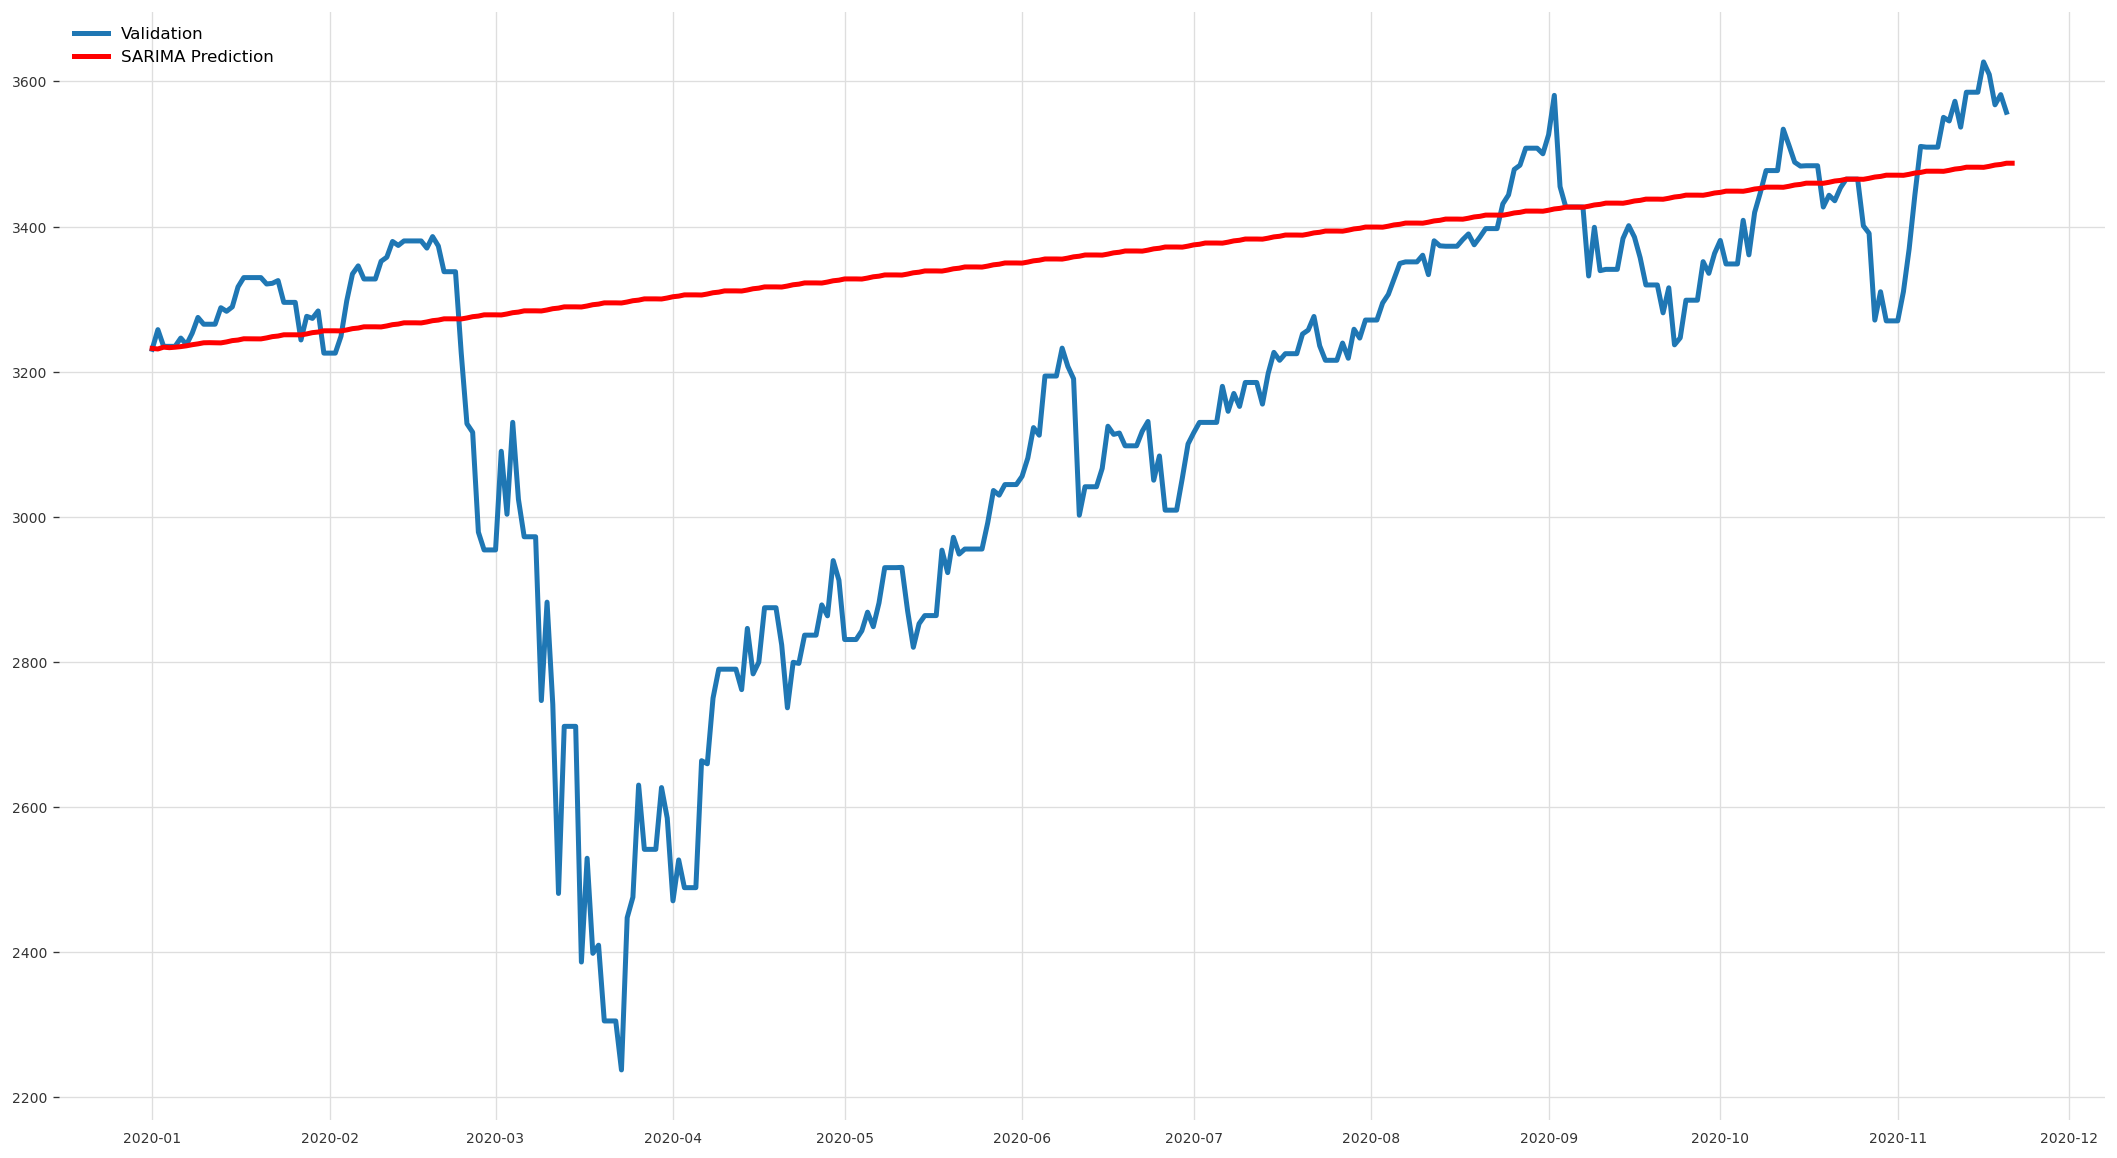

In [72]:
#plt.plot(train_data,label='Training',lw=3)
plt.plot(test_data,label='Validation',color='tab:blue',lw=3)
plt.plot(sar_pred,label="Explicit SARIMA Prediction",color='red',lw=3)
#plt.plot(pred,label="Auto ARIMA")
plt.legend(loc='upper left')
plt.show()

No difference between the explicitly defined SARIMA model, and the auto_arima, both linear prediction

# LSTM

In [36]:
lstm_model = BlockRNNModel(model='LSTM',input_chunk_length=28,output_chunk_length=7,n_epochs=100)
df = pd.read_csv('yahoo_stock.csv')

In [37]:
tsClose = TimeSeries.from_dataframe(df,'Date','Close')
tsOpen = TimeSeries.from_dataframe(df,'Date','Open')
tsHigh = TimeSeries.from_dataframe(df,'Date','High')
tsLow = TimeSeries.from_dataframe(df,'Date','Low')
tsAdjClose = TimeSeries.from_dataframe(df,'Date','Adj Close')

scClose,scOpen,scHigh,scLow,scAdjClose=Scaler(),Scaler(),Scaler(),Scaler(),Scaler()

sctsClose = scClose.fit_transform(tsClose)
sctsOpen = scOpen.fit_transform(tsOpen)
sctsHigh = scOpen.fit_transform(tsHigh)
sctsLow = scOpen.fit_transform(tsLow)
sctsAdjClose = scOpen.fit_transform(tsAdjClose)

split='2020-01-01'

trainclose,testclose = tsClose.split_before(pd.Timestamp(split))

ScTrainClose,ScTestClose = sctsClose.split_before(pd.Timestamp(split))
ScTrainOpen,ScTestOpen = sctsOpen.split_before(pd.Timestamp(split))
ScTrainHigh,ScTestHigh = sctsHigh.split_before(pd.Timestamp(split))
ScTrainLow,ScTestLow = sctsLow.split_before(pd.Timestamp(split))
ScTrainAdjClose,ScTestAdjClose = sctsAdjClose.split_before(pd.Timestamp(split))

In [38]:
lstm_model.fit(series=[ScTrainClose]) #1 variable
predictionLSTM1 = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTM1 = scClose.inverse_transform(predictionLSTM1)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 182   
---------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

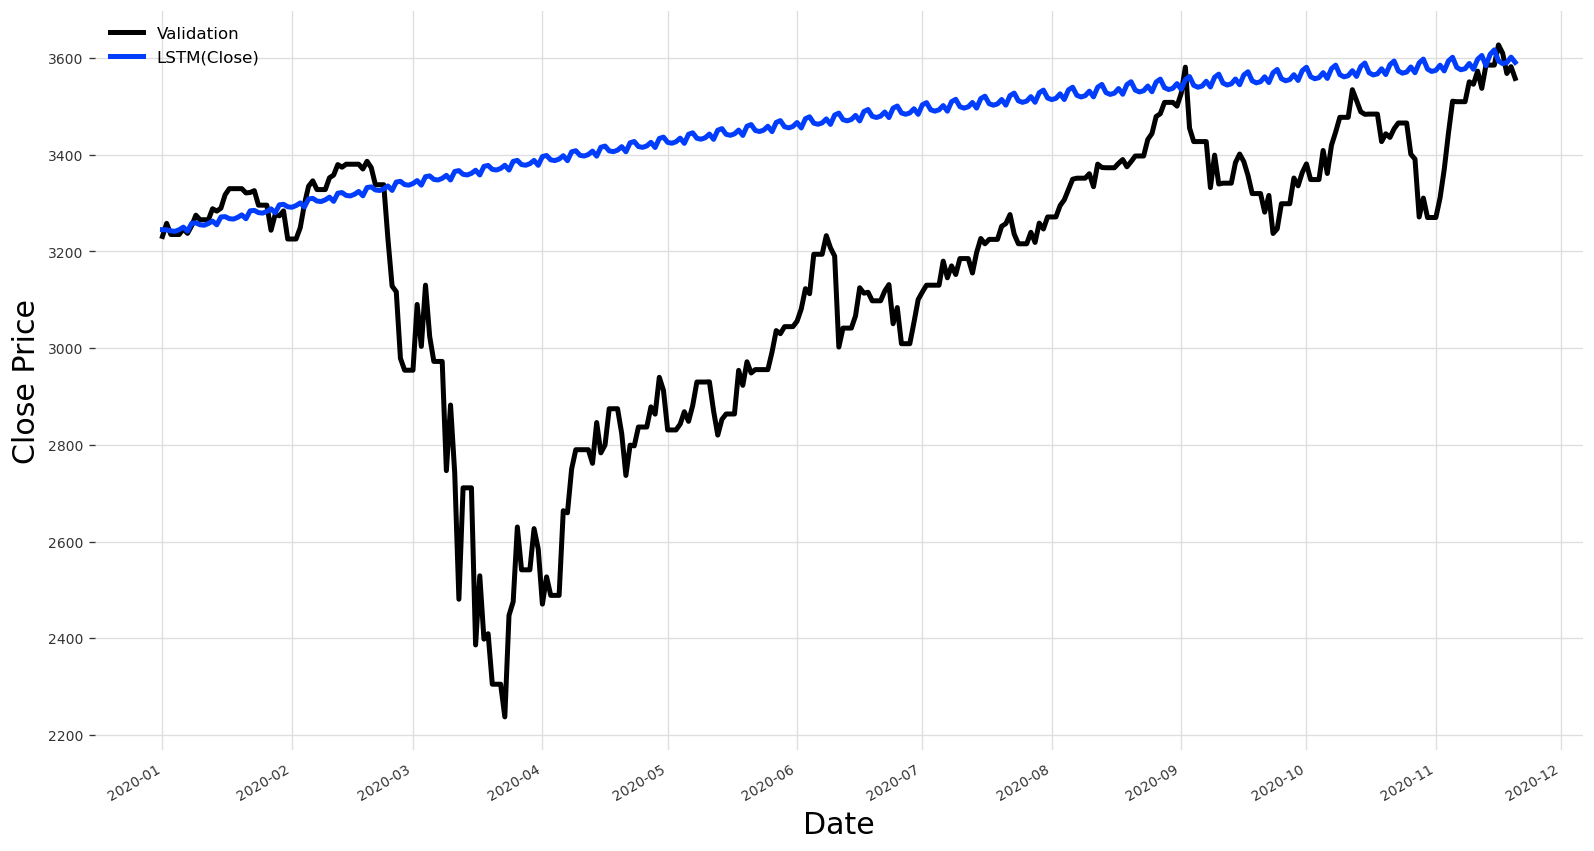

In [39]:
plt.figure(figsize=(16,8))
plt.title('LSTM Forecasting of Yahoo Stock')
testclose.plot(label='Validation',lw=3)
predictionLSTM1.plot(label='LSTM(Close)', lw=3)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

In [40]:
lstm_model.fit(series=[ScTrainClose,ScTrainOpen]) #2 variables
predictionLSTM = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTM = scClose.inverse_transform(predictionLSTM)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 182   
---------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

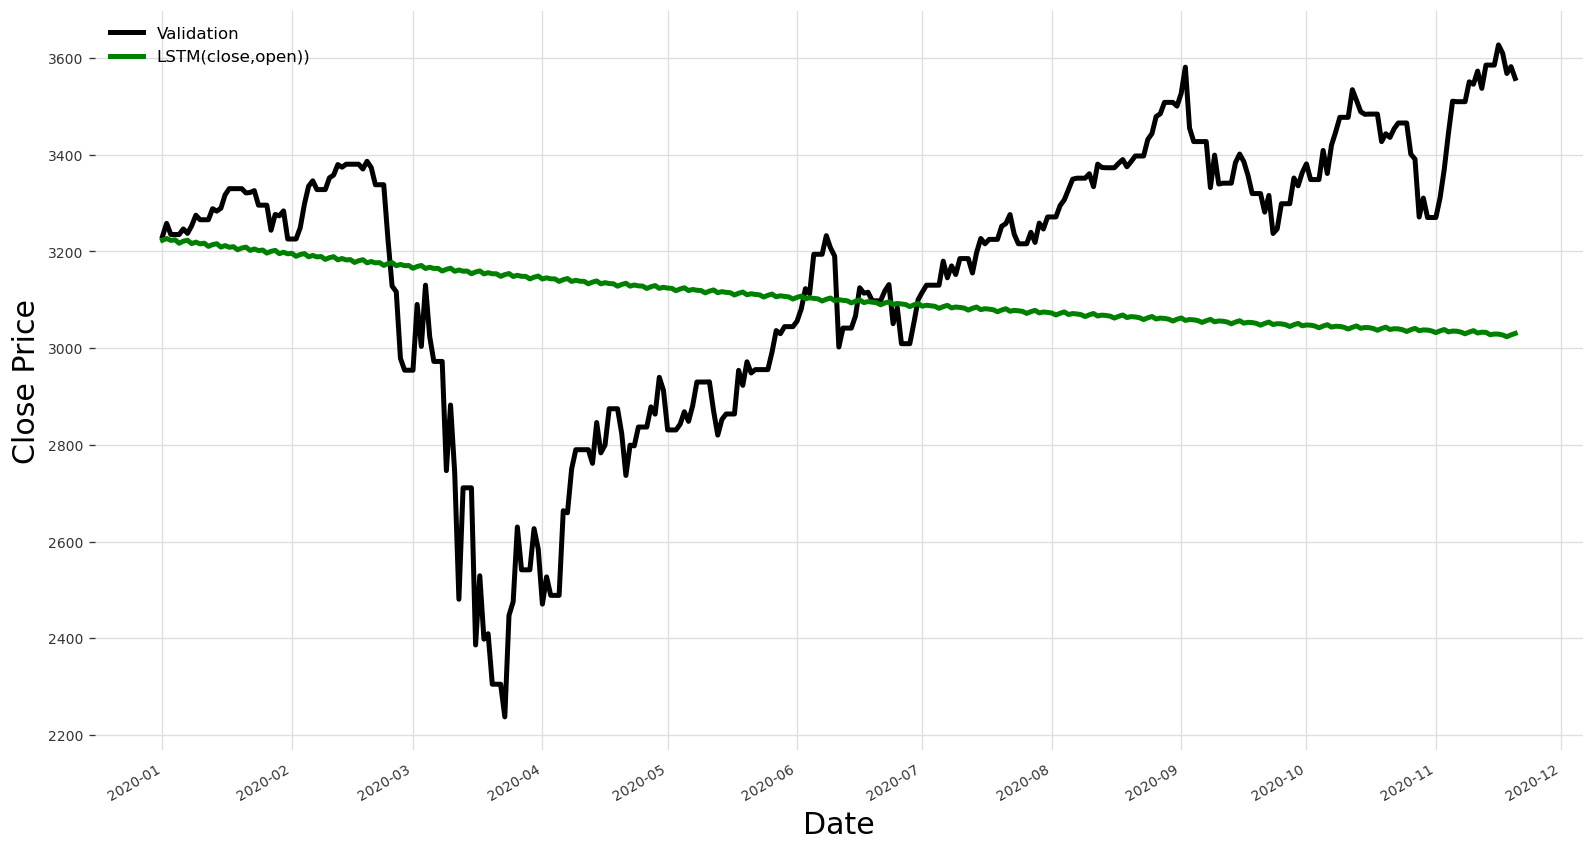

In [73]:
plt.figure(figsize=(16,8))
plt.title('LSTM Forecasting of Yahoo Stock')
testclose.plot(label='Validation',lw=3)
predictionLSTM.plot(label='LSTM(close,open))', lw=3,color='green')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

In [42]:
lstm_model.fit(series=[ScTrainClose,ScTrainOpen,ScTrainHigh]) #3 variables
predictionLSTM3 = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTM3 = scClose.inverse_transform(predictionLSTM3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 182   
---------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [43]:
lstm_model.fit(series=[ScTrainClose,ScTrainOpen,ScTrainHigh,ScTrainLow])#4 variables
predictionLSTM4 = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTM4 = scClose.inverse_transform(predictionLSTM4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 182   
---------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 182   
---------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

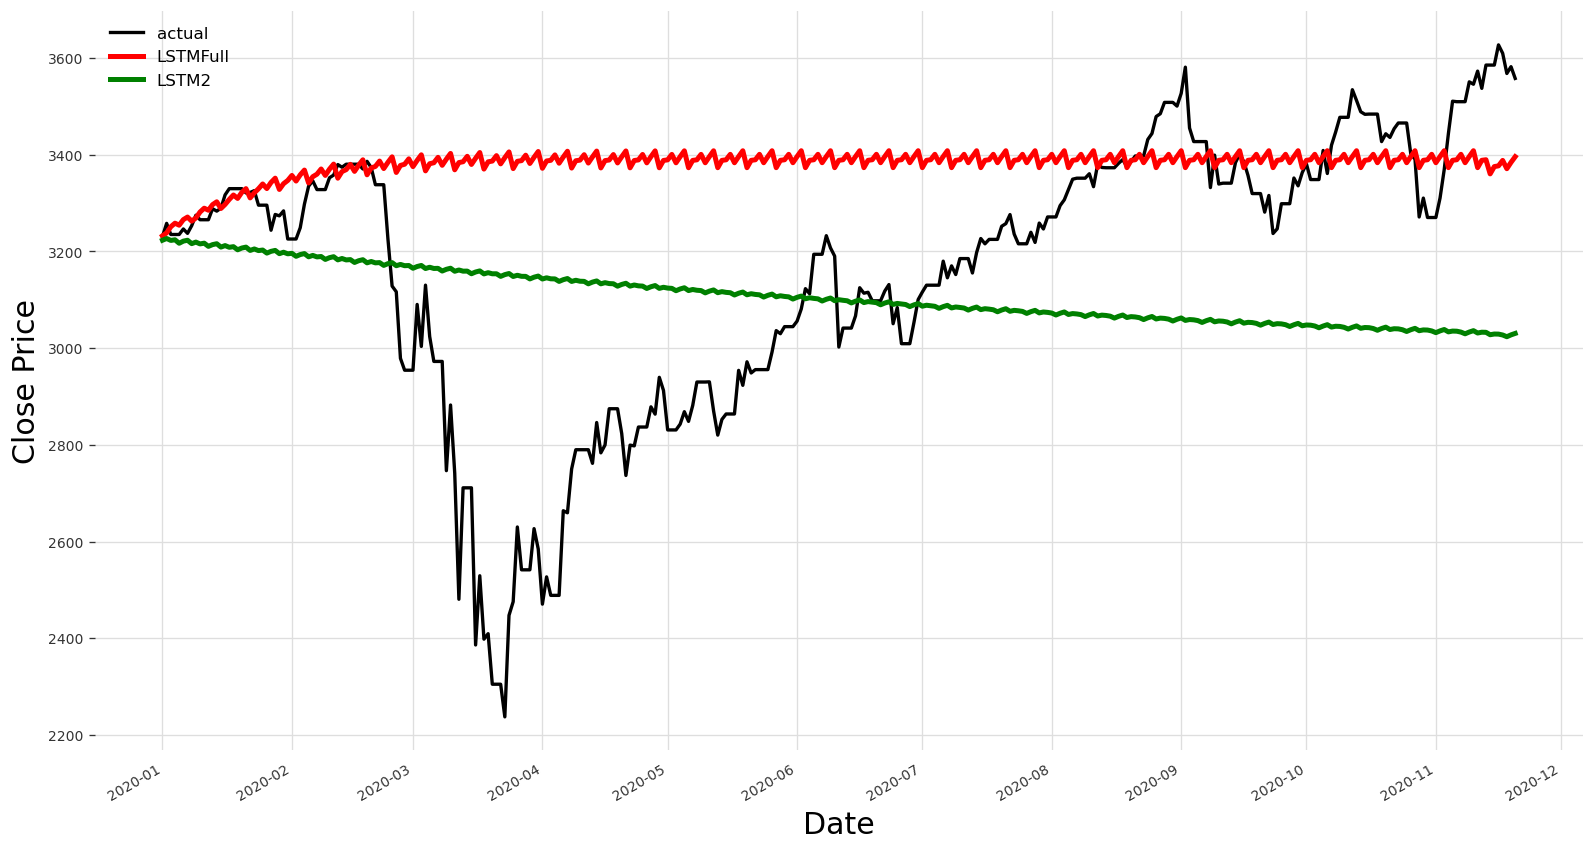

In [44]:
lstm_model.fit(series=[ScTrainClose,ScTrainOpen,ScTrainHigh,ScTrainLow,ScTrainAdjClose])
predictionLSTMFull = lstm_model.predict(n=len(ScTestClose), series=ScTrainClose)
predictionLSTMFull = scClose.inverse_transform(predictionLSTMFull)




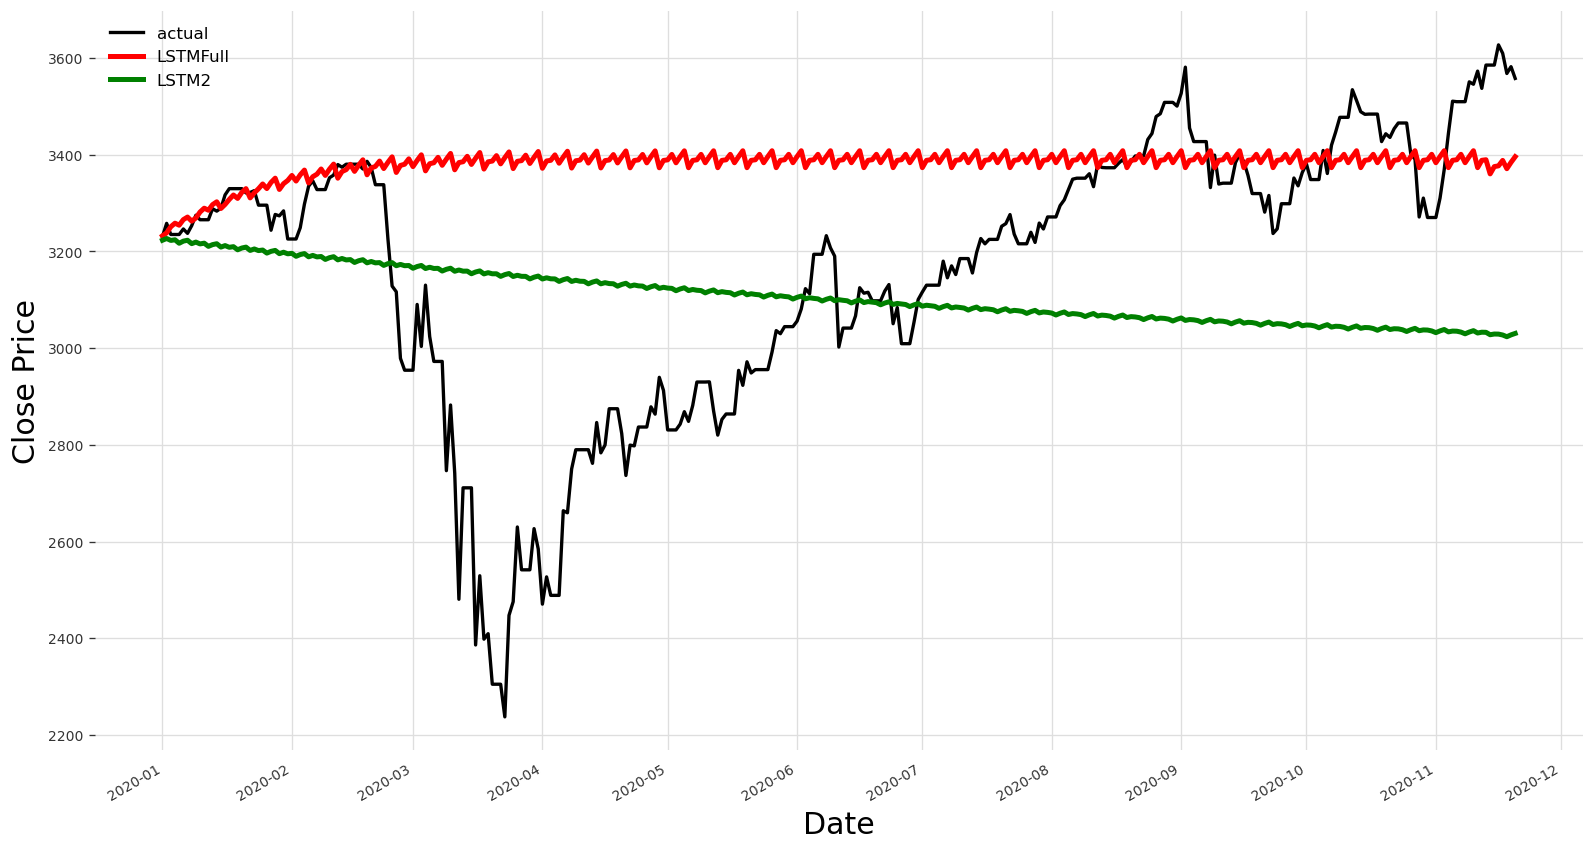

In [56]:
plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
testclose.plot(label='actual',color='black')
predictionLSTMFull.plot(label='LSTMFull', lw=3,color='red')
predictionLSTM.plot(label='LSTM2',lw=3,color='green')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

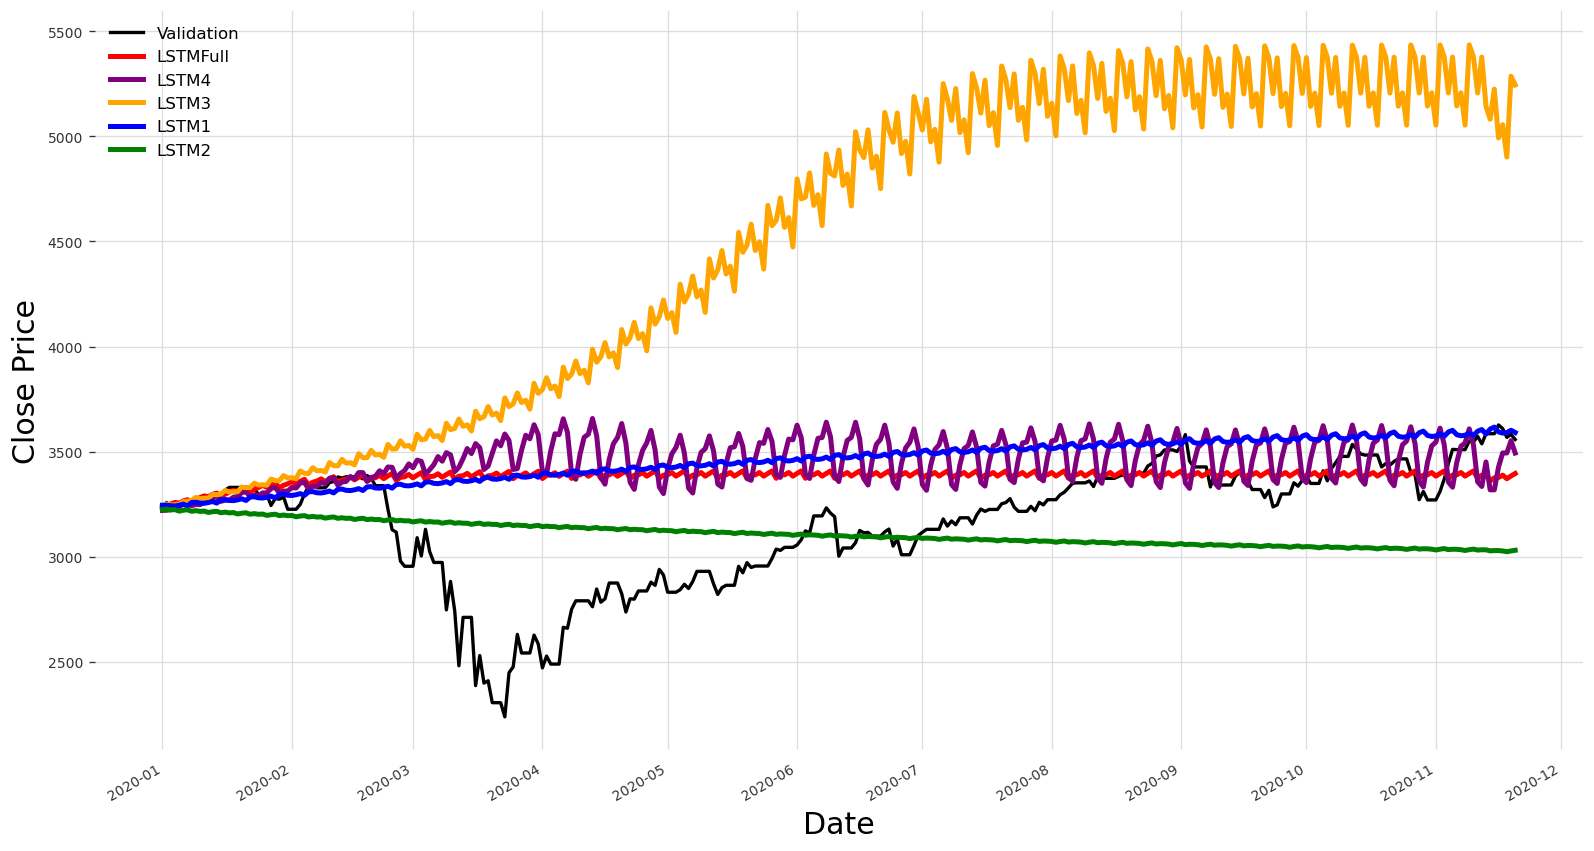

In [54]:
plt.figure(figsize=(16,8))
plt.title('Yahoo Stock Price Prediction')
testclose.plot(label='Validation',color='black')
predictionLSTMFull.plot(label='LSTMFull', lw=3,color='red')
predictionLSTM4.plot(label='LSTM4',lw=3,color='purple')
predictionLSTM3.plot(label='LSTM3',lw=3,color='orange')
predictionLSTM1.plot(label='LSTM1',lw=3,color='blue') #Only close value
predictionLSTM.plot(label='LSTM2',lw=3,color='green') #close + open
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend()
plt.show()

# PROPHET

In [60]:
proph_model = Prophet(seasonality_mode='multiplicative',yearly_seasonality=False,weekly_seasonality=True,daily_seasonality=False)
proph_model

Prophet(add_seasonalities=None, country_holidays=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None, seasonality_mode=multiplicative, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)

In [61]:
proph_model.fit(ScTrainClose)
proph_pred = proph_model.predict(n=len(ScTestClose),num_samples=200)

11:36:01 - cmdstanpy - INFO - Chain [1] start processing
11:36:01 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
prop_pred=scClose.inverse_transform(proph_pred)

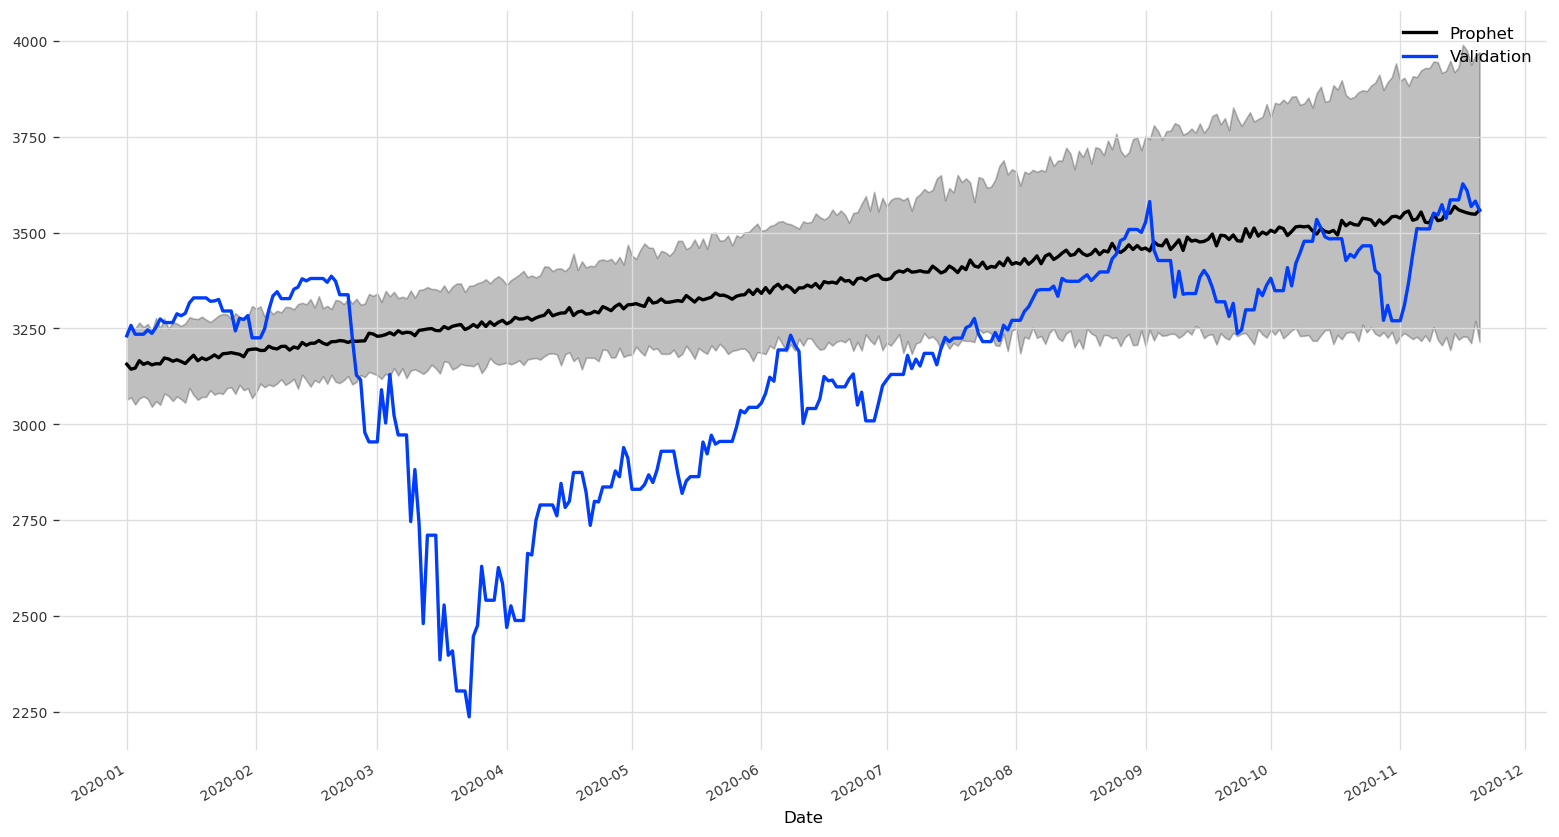

In [63]:
plt.figure(figsize=(16,8))
plt.title('prophet')
prop_pred.plot(label='Prophet')
testclose.plot(label='Validation')
plt.legend()
plt.show()

In [69]:
#Fixing the datatype/indexing of forecast
forecast = forecast.reset_index()
forecast = forecast.rename(columns={"index":"Date"})
forecast = forecast.set_index('Date')
forecast


,predicted_mean
Date,
2020-01-01,3230.728019
2020-01-02,3229.332427
2020-01-03,3230.770380
2020-01-04,3230.429564
2020-01-05,3229.638781
...,...
2020-11-16,3230.242169
2020-11-17,3230.242169
2020-11-18,3230.242169


In [70]:
print("mape for ARIMA:",mape(testclose,TimeSeries.from_dataframe(forecast)))
print("mape for SARIMA",mape(testclose,TimeSeries.from_dataframe(sar_pred)))
print("mape for LSTM1:", mape(testclose, predictionLSTM1))
print("mape for LSTM2:", mape(testclose, predictionLSTM))
print("mape for LSTM3:", mape(testclose, predictionLSTM3))
print("mape for LSTM4:", mape(testclose, predictionLSTM4))
print("mape for LSTMFull:", mape(testclose, predictionLSTMFull))
print("mape for prophet:",mape(testclose,prop_pred))

mape for ARIMA: 7.601599933675732
mape for SARIMA 8.122701948898312
mape for LSTM1: 10.471211448482503
mape for LSTM2: 8.5668092626519
mape for LSTM3: 42.734874686165014
mape for LSTM4: 11.101956921196535
mape for LSTMFull: 9.002789947818819
mape for prophet: 8.427857803427727
